In [0]:
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


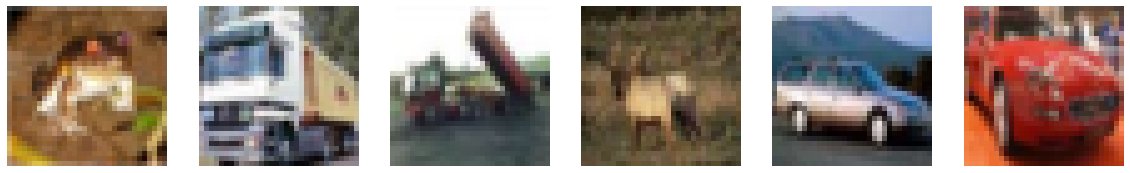

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# fuse the training set and the testing set
x_train = np.concatenate((x_train, x_test), axis = 0)/255

# check some images
fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=6, sharey=True, sharex=False)
for i in range(6):
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    im = axes[i].imshow(x_train[i])

In [0]:
class DCGAN:
    """
        A 4-layer generator - 4-layer discriminator Deep Convolutional Generative Adversarial Network
        
        Huperparameters and optimizers are defaulted to those describe in the paper: 
        
            UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL
            GENERATIVE ADVERSARIAL NETWORKS
            
            by 
            
            Alec Radford & Luke Metz
            indico Research
            Boston, MA {alec,luke}@indico.io
            
            Soumith Chintala
            Facebook AI Research New York, NY soumith@fb.com
    """
    
    def __init__(self, x_train, gen_dims=100):
        """
            Initializes the Deep Convolutional Gan
            
            Ags:
                x_train (np.array): the set we want to sample generated images from
                gen_dims (int): dimension of the noise for the generated images
        """
        
        self.training_set = x_train
        self.samples = []  # empty array to hold the samples
        self.losses = []  # empty array to hold the losses
        self.gen_dims = gen_dims
        self.weights = []
    
    def __generator(self, input_layer, kernel_size=5, reuse=False, lrelu_slope=0.2, kernel_initializer=tf.contrib.layers.xavier_initializer(), training=True):
        """
            Builds the generator CNN
            
            Args:
                input_layer (Tensor): The input layer to the network - gaussian noise placeholder
                kernel_initializer: weight initializer for the CNN layers
                kernel_size (int): size of the perceptive field
                reuse (bool): reuse parameter to reuse the variables
                lrelu_slope (np.float16): slope for the leaky relu activation function
                training (bool): batch normalization training
                
            Returns:
                out (Tensor): generated image
        """
        
        # use the xavier initializer for the weights
        w_init = kernel_initializer
        
        # use the variable scope to fetch the vars later
        with tf.variable_scope('generator', reuse=reuse):

            # reshape the noise into a volume
            input_dense = tf.layers.dense(inputs=input_layer, units=2*2*256)
            input_volume = tf.reshape(tensor=input_dense, shape=(-1, 2, 2, 256))
            h1 = tf.layers.batch_normalization(inputs=input_volume, training=training)  # batch norm
            h1 = tf.maximum(h1 * lrelu_slope, h1) # leaky relu
            # 2x2x256

            # deconv - upsample
            h2 = tf.layers.conv2d_transpose(filters=128, strides=2, kernel_size=kernel_size, padding='same', inputs=h1, activation=None, kernel_initializer=w_init)
            h2 = tf.layers.batch_normalization(inputs=h2, training=training)
            h2 = tf.maximum(h2 * lrelu_slope, h2) # leaky relu
            # 4x4x128

            # deconv - upsample
            h3 = tf.layers.conv2d_transpose(filters=64, strides=2, kernel_size=kernel_size, padding='same', inputs=h2, activation=None, kernel_initializer=w_init)
            h3 = tf.layers.batch_normalization(inputs=h3, training=training)
            h3 = tf.maximum(h3 * lrelu_slope, h3)
            # 8x8x64

            # deconv - upsample
            h4 = tf.layers.conv2d_transpose(filters=32, strides=2, kernel_size=kernel_size, padding='same', inputs=h3, activation=None, kernel_initializer=w_init)
            h4 = tf.layers.batch_normalization(inputs=h4, training=training)
            h4 = tf.maximum(h4 * lrelu_slope, h4)
            # 16x16x32

            # deconv - upsample
            logits = tf.layers.conv2d_transpose(filters=3, strides=2, kernel_size=kernel_size, padding='same', inputs=h4, activation=None, kernel_initializer=w_init)
            # 32x32x3

            # output image
            out = tf.tanh(x=logits)

            return out
    
    def __discriminator(self, input_layer, reuse=False, lrelu_slope=0.2, kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_size=5):
        """
            Builds the discriminator CNN
            
            Args:
                input_layer (Tensor): The input layer to the network - image from the training set
                kernel_initializer: weight initializer for the CNN layers
                kernel_size (int): size of the perceptive field
                reuse (bool): reuse parameter to reuse the variables
                lrelu_slope (np.float16): slope for the leaky relu activation function
                
            Returns:
                out (Tensor): probability that the image is generated
                logits (Tensor): logits of the discriminator
        """
        
        # use the xavier initializer for the weights
        w_init = kernel_initializer
        
        with tf.variable_scope('discriminator', reuse=reuse):
        
            # conv - 32x32x3 -> 16x16x364 -- we don't use the batch norm on the first layer of discriminator
            h1 = tf.layers.conv2d(inputs=input_layer, filters=32, strides=2, kernel_size=kernel_size, padding='same', kernel_initializer=w_init)
            h1 = tf.maximum(h1 * lrelu_slope, h1)

            # conv - 16x16x64 -> 8x8x128
            h2 = tf.layers.conv2d(inputs=h1, filters=64, strides=2, kernel_size=kernel_size, padding='same', kernel_initializer=w_init)
            h2 = tf.layers.batch_normalization(inputs=h2, training=True)
            h2 = tf.maximum(h2 * lrelu_slope, h2)

            # conv - 8x8x128 -> 4x4x256
            h3 = tf.layers.conv2d(inputs=h2, filters=128, strides=2, kernel_size=kernel_size, padding='same', kernel_initializer=w_init)
            h3 = tf.layers.batch_normalization(inputs=h3, training=True)
            h3 = tf.maximum(h3 * lrelu_slope, h3)

            # conv - 4x4x256 -> 2x2x512
            h4 = tf.layers.conv2d(inputs=h3, filters=256, strides=2, kernel_size=kernel_size, padding='same', kernel_initializer=w_init)
            h4 = tf.layers.batch_normalization(inputs=h4, training=True)
            h4 = tf.maximum(h4 * lrelu_slope, h4)

            # flatten the array
            flatten = tf.reshape(tensor=h4, shape=(-1, 2*2*256))

            # logits
            logits = tf.layers.dense(inputs=flatten, units=1, activation=None, kernel_initializer=w_init)

            # output
            out = tf.sigmoid(x=logits)

            return out, logits
    
    def __inputs(self):
        """
            Creates the imput tensors for the generator and the discriminator
            
            Returns:
                gen_input (Tensor): input placeholder for the generator
                real_input (Tensor): input placeholder for the discriminator
        """
        
        # define the input placeholders
        gen_input = tf.placeholder(shape=(None, self.gen_dims), dtype=tf.float32)
        real_input = tf.placeholder(shape=(None, 32, 32, 3), dtype=tf.float32)
        
        return gen_input, real_input
    
    def __setup_losses_and_optimizers(self, lr=0.0005, beta1=0.5, beta2=0.999):
        """
            Builds the computational graph for the network
            
            Args:
                lr (float): learning rate for the optimizer
                beta1 (float): beta1 parameter for the ADAM optimizer
                beta2 (float): beta2 parameter for ADAM
            
            Returns:
                discriminator_optimizer: optimizer op for the discriminator 
                generator_optimizer: optimizer op for the generator
                disc_loss: discriminator loss
                gen_loss: generator loss
                gen_input: pass through generator input - noise
                real_input: pass through real image input
        """
        
        # - - - BUILD THE GRAPH - - -      
        # reset the default graph
        tf.reset_default_graph()

        # define the input placeholders
        gen_input, real_input = self.__inputs()
        
        # build the generator
        gen_images = self.__generator(input_layer=gen_input, 
                                      kernel_size=5, 
                                      reuse=False, 
                                      lrelu_slope=0.2, 
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                      training=True)

        # build the discriminator for the real images
        disc_output_real_image, disc_logits_real_image = self.__discriminator(input_layer=real_input, 
                                                                              reuse=False, 
                                                                              lrelu_slope=0.2,
                                                                              kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                                                              kernel_size=5)
        
        # build the discriminator for fake images
        # reuse the variables that we have from the real images
        disc_output_gen_image, disc_logits_gen_image = self.__discriminator(input_layer=gen_images, 
                                                                            reuse=True, 
                                                                            lrelu_slope=0.2, 
                                                                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                                                            kernel_size=5)

        # - - - LOSSES - - -
        # generator loss
        gen_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_gen_image, multi_class_labels=tf.ones_like(disc_logits_gen_image)))
        
        # discriminator loss
        disc_loss_real_images = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_real_image, multi_class_labels=tf.ones_like(disc_logits_real_image)))
        disc_loss_gen_images = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(logits=disc_logits_gen_image, multi_class_labels=tf.zeros_like(disc_logits_gen_image)))
        disc_loss = disc_loss_real_images + disc_loss_gen_images

        # get the variables for the generator and discriminator
        generator_variables = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
        discriminator_variables = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

        # setup the optimizers
        # comtrol for the global sample mean and variance
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            generator_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(gen_loss, var_list=generator_variables)
            discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(disc_loss, var_list=discriminator_variables)
        
        return discriminator_optimizer, generator_optimizer, disc_loss, gen_loss, gen_input, real_input
    
    def train(self, batch_size=128, epochs=100):
        """
            Trains the DCGAN
            
            Args:
                batch_size (int): size of a batch
                epochs (int): number of epochs to train for
        """
        
        d_opt, g_opt, d_loss, g_loss, gen_input, real_input = self.__setup_losses_and_optimizers()
        
        # - - - TRAIN - - -
        # run the session
        with tf.Session() as sess:

            # initialize the variables
            sess.run(tf.global_variables_initializer())

            # train the network
            for epoch in tqdm(range(epochs)):

                for step, batch in enumerate(self.__next_batch(self.training_set, batch_size)):
                    
                    # generate the noise
                    noise = np.random.uniform(low=-1, high=1, size=(batch_size, self.gen_dims))

                    # feed the noise through the generator
                    _ = sess.run(g_opt, feed_dict={gen_input: noise, real_input: batch})

                    # feed the channel and the noise to the discriminator
                    _ = sess.run(d_opt, feed_dict={gen_input: noise, real_input: batch})

                    # get the generator and discriminator losses
                    gen_loss, disc_loss = sess.run([g_loss, d_loss], feed_dict={gen_input: noise, real_input: batch})
                    
                    # append all the losses on every iteration
                    self.losses.append((gen_loss, disc_loss))
                
                # every second epoch
                if epoch % 2 == 0:
                    # sample more noise
                    sample_noise = np.random.uniform(low=-1, high=1, size=(72, self.gen_dims))

                    # generate images
                    gen_samples = sess.run(self.__generator(gen_input, reuse=True, training=False), feed_dict={gen_input: sample_noise})
                    
                    # append the images to the samples
                    self.samples.append(gen_samples)
                    
                    # view samples from the last epoch
                    _ = self.view_samples(-1, self.samples, 6, 12, figsize=(10,5))
                    plt.show()
                
    def __next_batch(self, data, batch_size=128):
        """
            Generates the batches of data
        
            Args:
                batch_size (int): size of the batch
        
            Returns:
                batch based on the batch_size
        """
        
        # get the number of partitions
        number_of_partitions = data.shape[0]//batch_size

        # shuffle the examples
        np.random.shuffle(self.training_set)

        # partition the examples
        for batch in np.array_split(self.training_set[:number_of_partitions*batch_size], number_of_partitions):
            yield batch * 2 - 1  # scale to -1 to 1
    
    def view_samples(self, epoch, samples, nrows, ncols, figsize=(5, 5)):
        """
            Shows generated samples
            The function is taken from Udacity's DL nanodegree course
            
            Args:
                epoch (int): the epochs to fetch the samples from 
                nrows (int): number of rows in the grid
                ncols (int): number of columns in the grid
                figsize (int, int): figure size
                
            Returns:
                fig (matplotlib.figure.Figure): figure object
                axes (matplotlib.axes._subplots.AxesSubplot): ax objects
        """
        
        # ge the figure and the axes
        fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)

        # draw the samples
        for ax, img in zip(axes.flatten(), samples[epoch]):
            ax.axis('off')
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
            ax.set_adjustable('box-forced')
            im = ax.imshow(img, aspect='equal')
        plt.subplots_adjust(wspace=0, hspace=0)
        return fig, axes

In [0]:
gan = DCGAN(x_train)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


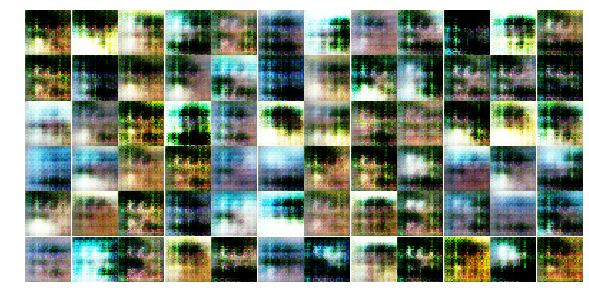

  7%|▋         | 2/30 [02:33<36:35, 78.42s/it]

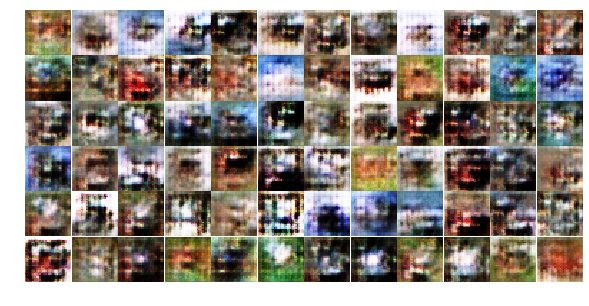

 13%|█▎        | 4/30 [05:03<33:08, 76.50s/it]

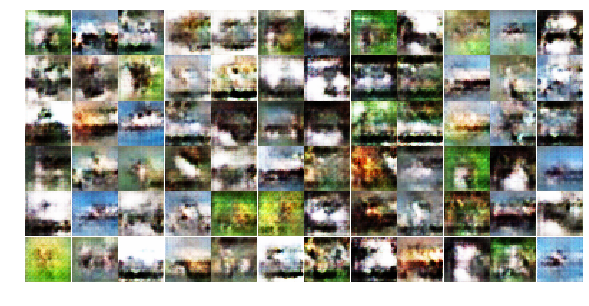

 20%|██        | 6/30 [07:33<30:12, 75.53s/it]

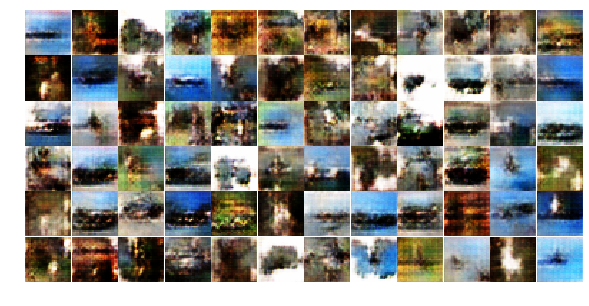

 27%|██▋       | 8/30 [10:03<27:31, 75.06s/it]

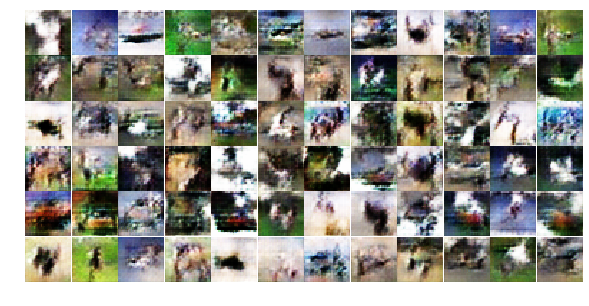

 33%|███▎      | 10/30 [12:33<24:57, 74.86s/it]

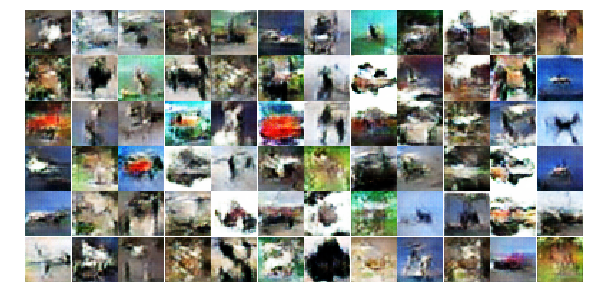

 40%|████      | 12/30 [15:03<22:25, 74.74s/it]

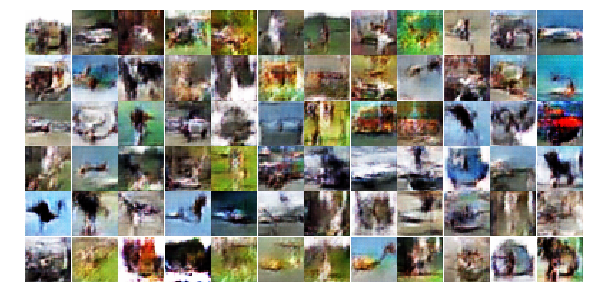

 47%|████▋     | 14/30 [17:33<19:54, 74.66s/it]

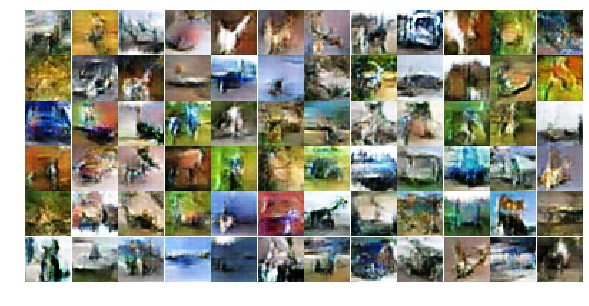

 53%|█████▎    | 16/30 [20:03<17:25, 74.68s/it]

KeyboardInterrupt: ignored

In [0]:
gan.train(batch_size=128, epochs=30)